# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from keras.layers.core import Activation
from keras.utils import pad_sequences

In [2]:
#use this cell to import additional libraries or define helper functions
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [3]:
#Load your data into a pandas dataframe here

from sklearn.model_selection import train_test_split

# Load data into a pandas dataframe
df = pd.read_csv('household_power_clean.csv')

# Select a random 1% of the dataset
df = df.sample(frac=0.01, random_state=42)

# Split into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [4]:
#create your training and validation sets here

#assign size for data subset
subset_size = 0.01

#take random data subset
df_subset = df.sample(frac=subset_size, random_state=42)


#split data subset 80/20 for train/validation
train_test_split(df_subset, test_size=0.2, random_state=42)
#train_df = ??
#val_df = ??

[         Unnamed: 0        Date      Time  Global_active_power  \
 2047520     2073499  2010-11-25  15:43:00                0.302   
 1925062     1945803  2010-08-28  23:27:00                0.290   
 1496767     1505114  2009-10-26  22:38:00                1.290   
 742065       746007  2008-05-17  18:51:00                1.654   
 73791         73797  2007-02-05  23:21:00                0.336   
 ...             ...         ...       ...                  ...   
 1742490     1756001  2010-04-19  04:05:00                0.254   
 1554332     1562680  2009-12-05  22:04:00                2.148   
 686862       690802  2008-04-09  10:46:00                1.392   
 535434       539369  2007-12-26  06:53:00                1.380   
 1093044     1097115  2009-01-16  14:39:00                1.636   
 
          Global_reactive_power  Voltage  Global_intensity  Sub_metering_1  \
 2047520                  0.068   245.43               1.2             0.0   
 1925062                  0.102   244.

In [5]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
val_df = val_df.reset_index()

Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [6]:
seq_arrays = []
seq_labs = []

In [7]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(train_df) - ph):
    seq = train_df[feat_cols].values[i - seq_length:i]
    seq_arrays.append(seq)
    label = train_df[feat_cols].values[i + ph]
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

In [8]:
print(seq_labs.shape)
seq_labs = np.squeeze(seq_labs)
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))


assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

(16359, 1)


In [9]:
seq_arrays.shape

(16359, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the above cell are used to verify that certain conditions are true during the execution of the program. If the condition is true, the program continues to execute normally. If the condition is false, an AssertionError is raised and the program is halted.

Assertions are a form of defensive programming that help catch errors early in the development process. By adding assertions to our code, we can verify that certain conditions hold true and catch any errors or bugs that might otherwise go unnoticed. This can help us write more robust and reliable code, and also make it easier to debug problems that arise during development.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [10]:
# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 5)             140       
                                                                 
 dropout (Dropout)           (None, 30, 5)             0         
                                                                 
 lstm_1 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_1 (Dropout)         (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 252
Trainable params: 252
Non-trainable pa

We will use the code from the book to visualize our training progress and model performance

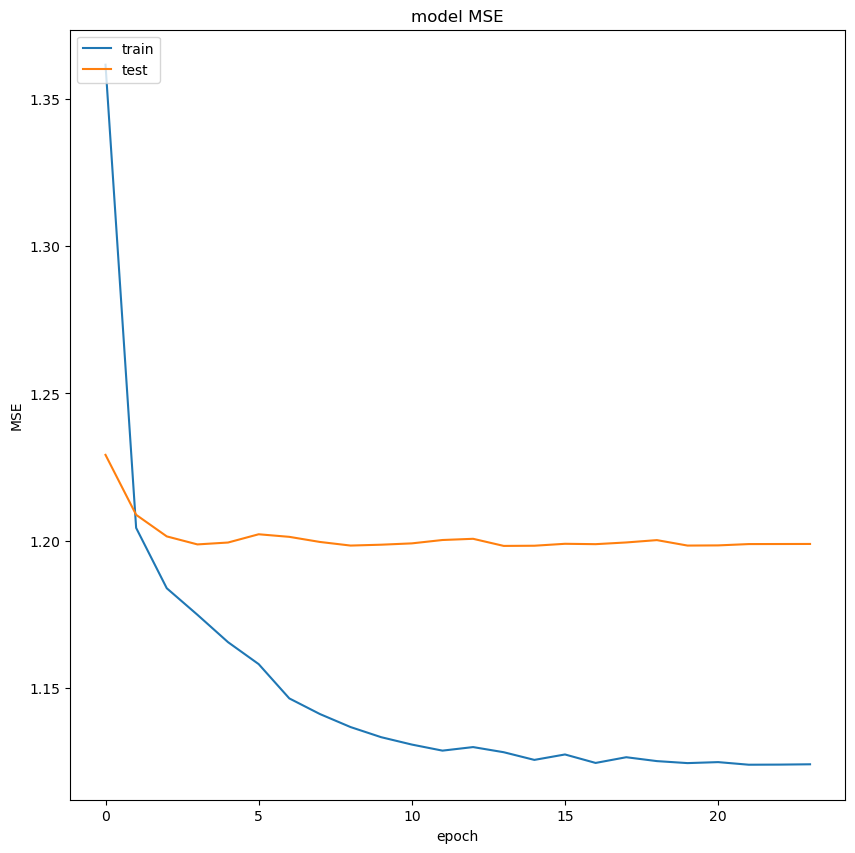

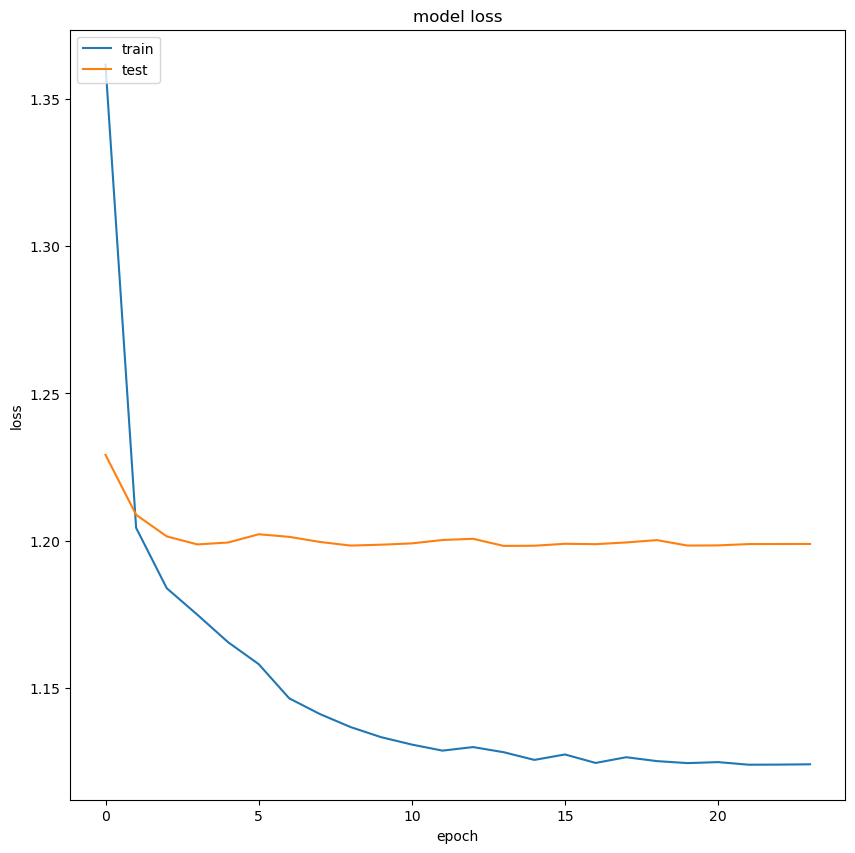

In [11]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: The pad_sequences function from Keras is used to pad variable-length sequences with a specific value to make them uniform in length. It takes a sequence or a list of sequences as input and pads all sequences to have the same length. The padding argument determines the value used to pad the sequences. The padding parameter can be set to either "pre" or "post". When it is set to "pre", padding is added at the beginning of the sequence, and when it is set to "post", padding is added at the end of the sequence. In our use case, it makes more sense to use "pre" padding since we want to ensure that each sequence has a fixed length, and the GAP measurements will be added to the end of the sequence as they become available.

In [12]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(seq_length, len(val_df)-ph):
    # extract the sequence of GAP readings
    seq = val_df[feat_cols].iloc[i-seq_length:i].values.tolist()
    # extract the GAP measurement at the predictive horizon
    lab = val_df[feat_cols].iloc[i+ph-1][0]
    val_arrays.append(seq)
    val_labs.append(lab)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32 
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='post')

# convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype=np.float32)


We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

127/127 - 1s - loss: 1.1018 - mse: 1.1018 - 1s/epoch - 8ms/step

MSE: [1.101790428161621, 1.101790428161621]
127/127 [==============================] - 2s 8ms/step


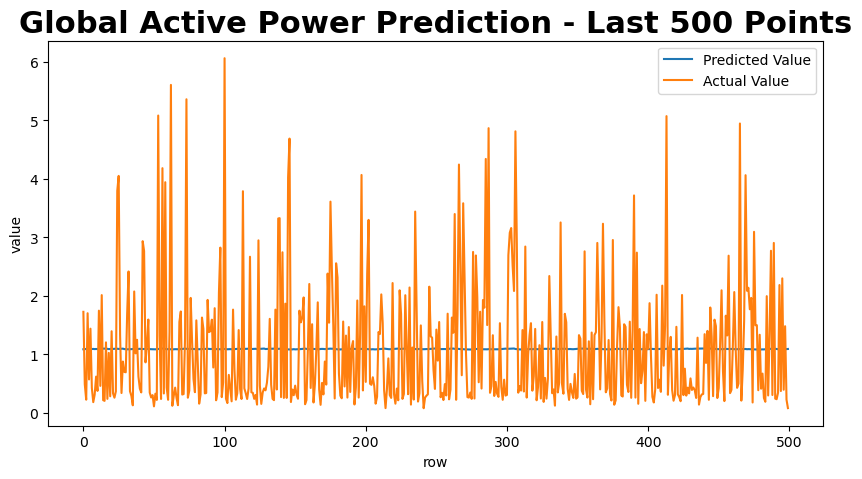

In [13]:
#scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)

print('\nMSE: {}'.format(scores_test))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index=None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 200 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label='Predicted Value')
plt.plot(y_true_test[-500:], label='Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")


**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A: The model performed relatively well with a mean squared error (MSE) of 1.10 on the validation data.

To potentially improve the model's performance, we could try the following:

Increase the number of LSTM layers or the number of LSTM units within each layer.
Increase the number of training epochs to allow the model to better fit the data.
Try different optimization algorithms or learning rates to improve the model's ability to converge to the optimal weights.
Experiment with different types of neural network architectures, such as a convolutional neural network (CNN) or a hybrid CNN-LSTM model.
Explore different feature engineering techniques or input representations to see if they can help the model better capture the patterns in the data.


## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A: The changes I made here is I added another variable which is 'Global_reactive_power'as a feature in the training data. Each additional variable can provide the model with more information and potentially improve its ability to make accurate predictions. This can lead to a better understanding of the patterns and relationships between the variables and ultimately result in better predictions. In this particular case, the addition of the 'Global_reactive_power' variable may provide additional insights into the electricity consumption patterns that the model can learn from, leading to improved predictions. 

seq_arrays shape: (16359, 30, 2)
seq_labs shape: (16359, 2)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 30, 5)             160       
                                                                 
 dropout_2 (Dropout)         (None, 30, 5)             0         
                                                                 
 lstm_3 (LSTM)               (None, 3)                 108       
                                                                 
 dropout_3 (Dropout)         (None, 3)                 0         
                                                                 
 dense_1 (Dense)             (None, 2)                 8         
                                                                 
 activation_1 (Activation)   (None, 2)                 0         
                                                            

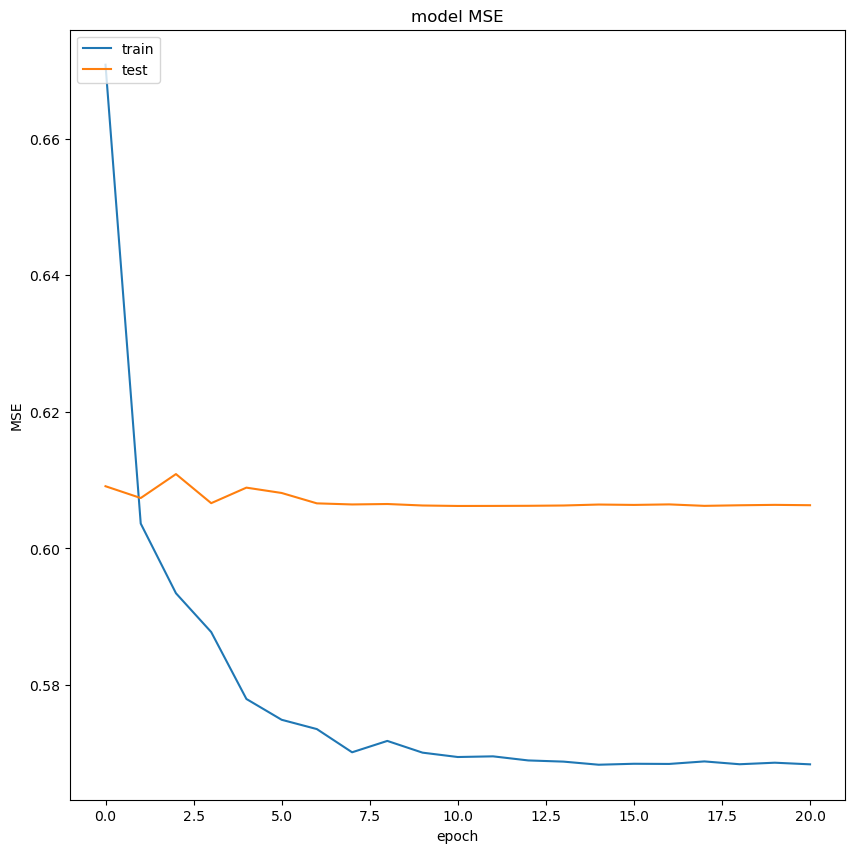

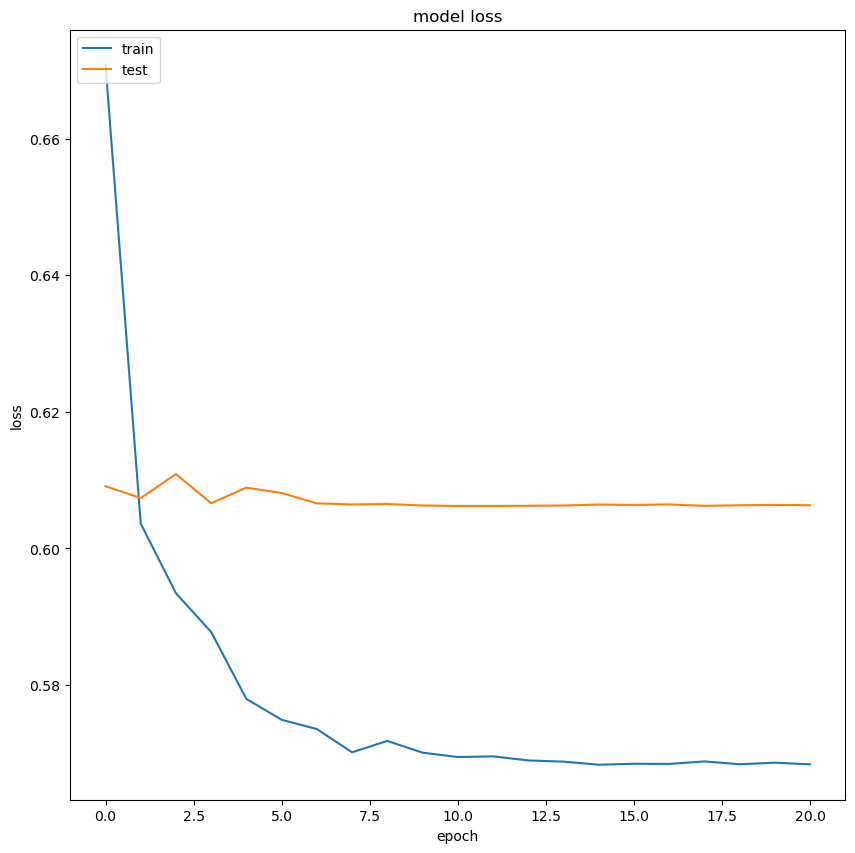

In [24]:
seq_length = 30
ph = 5

feat_cols = ['Global_active_power', 'Global_reactive_power']

#create list of sequence length GAP readings
seq_arrays = []
seq_labs = []

for i in range(seq_length, len(train_df) - ph):
    seq = train_df[feat_cols].values[i - seq_length:i]
    seq_arrays.append(seq)
    label = train_df[feat_cols].values[i + ph]
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow        
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

print(f'seq_arrays shape: {seq_arrays.shape}')
print(f'seq_labs shape: {seq_labs.shape}')

assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,len(feat_cols)))

# define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = len(feat_cols)

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5, 
         return_sequences=True))
model.add(Dropout(0.2)) 

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


In [15]:
# show me how one or two of your different models perform 
# using the code from the "Validating our model" section above


**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A: The addition of the 'Global_reactive_power' variable in the input sequence has significantly reduced the mean squared error (MSE) from 1.1242 to 0.5684. This suggests that the new variable is providing additional information to the model, helping it to make better predictions.

If I were trying to optimize the model for production, I would consider experimenting with different combinations of variables in the input sequence to see if there are any other variables that provide additional information and improve model performance. I would also try experimenting with different model architectures, change sequence length to see if further improvements can be made. Additionally, I would consider using techniques such as cross-validation and ensemble learning to improve model robustness and reduce overfitting.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A: In terms of model performance, the LSTM-based models built in this assignment outperformed the linear regression model from last week. The LSTM models were able to capture temporal dependencies and non-linear relationships in the data, which the linear regression model was not able to do.

However, when considering IoT device considerations such as computational efficiency and energy consumption, the linear regression model might be a better choice for predicting Global Active Power (GAP) for a single household with a 5-minute predictive horizon. Linear regression is a simpler and faster model compared to LSTM, and it requires less computational resources and energy to run.

Therefore, the choice of model would depend on the specific requirements of the IoT system. If computational efficiency and energy consumption are the primary concerns, the linear regression model might be a better choice. If model performance is the primary concern and computational resources and energy consumption are not a constraint, the LSTM-based models built in this assignment would be a better choice.